# Train Queryable Input Classifier
This notebook trains an LSTM model that classifies whether the user's input can be queryable, in that the model should extract keywords to look online via the citation fetcher class.

In [1]:
from datasets import Dataset, DatasetDict
from matplotlib import pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics
from torchtext import data, datasets

import const
import datasets
import pandas as pd
import numpy as np
import torchtext
import torch
import torch.nn as nn
import random
import spacy
import subprocess

In [2]:
TEXT = data.Field(tokenize="spacy", tokenizer_language="en_core_web_sm")

In [3]:
LABEL = data.LabelField(dtype= torch.long)

In [4]:
TRAINING_DS_PATH = const.DATASETS_FOLDER + "QI_training.csv"
TESTING_DS_PATH = const.DATASETS_FOLDER + "QI_testing.csv"

FEATURE_COL = "question"
LABEL_COL = "is_searchable"

In [5]:
TRAIN_SPLIT = 0.7

# MODEL PARAMETERS
CORPUS_SIZE = 25000
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
EPOCHS = 50

EMBEDDING_DIM = 256
HIDDEN_DIM = 512
OUTPUT_DIM = 2
DEVICE = "auto"

In [6]:
MODEL_NAME = "aletheianomous_ai-QI_class-v0.1.4" 
MODEL_SAVE_PATH = (const.MODELS_FOLDER + MODEL_NAME + "/"
       + "model.pt")
VOCAB_SAVE_PATH = (const.MODELS_FOLDER + MODEL_NAME + "/vocab.pt")
LABEL_VOCAB_PATH = (const.MODELS_FOLDER + MODEL_NAME + "/label_vocab.pt")

In [7]:
if DEVICE == "auto":
    if torch.cuda.is_available():
        selected_device = "cuda"
    else:
        selected_device = "cpu"
else:
    selected_device = DEVICE

In [8]:
selected_device

'cuda'

In [9]:
training_df = pd.read_csv(TRAINING_DS_PATH)
testing_df = pd.read_csv(TESTING_DS_PATH)

/tmp/ipykernel_487245/2416222827.py:1: DtypeWarning: Columns (2,3,4,6,7,8,9,14) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(TRAINING_DS_PATH)


In [10]:
len(training_df)

204726

In [11]:
split_ind = int(len(training_df) * TRAIN_SPLIT)
training_df = training_df.sample(frac=1)
training_df = training_df.reset_index()

validation_df = training_df[split_ind:]
validation_df = validation_df.reset_index()
training_df = training_df[0:split_ind]

In [12]:
len(training_df)

143308

In [13]:
len(validation_df)

61418

In [14]:
training_df.tail()

,index,Unnamed: 0.4,Unnamed: 0,source,topic,paragraph,question,question_id,is_impossible,answers,expanded_answers,is_searchable,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,data
143303,154329,154329,24010.0,NaN,NaN,NaN,Who are the members of The Smiths and what rol...,NaN,NaN,NaN,NaN,1.0,24010.0,24010.0,24010.0,['Who are the members of The Smiths and what r...
143304,196763,196763,NaN,NaN,NaN,NaN,"Try learning French. The table is male, the ch...",NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
143305,157016,157016,26697.0,NaN,NaN,NaN,What are the most popular hiking trails in the...,NaN,NaN,NaN,NaN,1.0,26697.0,26697.0,26697.0,['What are the most popular hiking trails in t...
143306,127719,127719,127719.0,Squad 2.0,University_of_Notre_Dame,The College of Arts and Letters was establishe...,How many BA majors does the College of Arts an...,5733a3cbd058e614000b5f43,False,33,"d in O'Shaughnessy Hall, includes 20 departmen...",1.0,NaN,NaN,NaN,NaN
143307,150810,150810,20491.0,NaN,NaN,NaN,What are some highly-rated weightlifting routi...,NaN,NaN,NaN,NaN,1.0,20491.0,20491.0,20491.0,['What are some highly-rated weightlifting rou...


In [15]:
validation_df.tail()

,level_0,index,Unnamed: 0.4,Unnamed: 0,source,topic,paragraph,question,question_id,is_impossible,answers,expanded_answers,is_searchable,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,data
61413,204721,63076,63076,63076.0,Squad 2.0,Pesticide,Pesticides safety education and pesticide appl...,Who has the ability to make the choice of usin...,5726b952708984140094cf3f,False,applicators,onment from pesticide use. Integrated pest man...,1.0,NaN,NaN,NaN,NaN
61414,204722,29221,29221,29221.0,Squad 2.0,Bird_migration,The primary motivation for migration appears t...,What do diurnal birds produce as opposed to no...,5705f85275f01819005e77ea,False,larger clutches,to produce larger clutches than related non-mi...,1.0,NaN,NaN,NaN,NaN
61415,204723,98652,98652,98652.0,Squad 2.0,Rajasthan,"Traditionally the Rajputs, Jats, Meenas, Gurja...",Members of what group were killed in Jats and ...,5a46b4c75fd40d001a27dc7f,True,Gurjars,ture and the land. Millions of them were kille...,1.0,NaN,NaN,NaN,NaN
61416,204724,51956,51956,51956.0,Squad 2.0,Dutch_language,"Next to sound shifts, there are ample examples...",Would linguistic differences make it difficult...,57265bf4f1498d1400e8dd25,False,easy,"n example. In that language, the words ""ja"" (y...",1.0,NaN,NaN,NaN,NaN
61417,204725,68336,68336,68336.0,Squad 2.0,Nutrition,Nutritionism is the view that excessive relian...,What is the term that refers to a viewpoint th...,572710d0f1498d1400e8f2ec,False,Nutritionism,ely on nutrition experts to advise on food cho...,1.0,NaN,NaN,NaN,NaN


In [ ]:
validation_df.to_csv(const.DATASETS_FOLDER + "QI_validation.csv")

In [16]:
torch.backends.cudnn.deterministic=True

In [17]:
labels = training_df[LABEL_COL].unique()

In [18]:
weights = compute_class_weight(class_weight="balanced", classes=labels, y=training_df[LABEL_COL].to_numpy())

In [19]:
loss_weights = torch.Tensor(weights)
#loss_weights = None

In [20]:
testing_df.columns

Index(['Unnamed: 0.4', 'Unnamed: 0', 'source', 'topic', 'paragraph',
       'question', 'question_id', 'is_impossible', 'answers',
       'expanded_answers', 'is_searchable', 'Unnamed: 0.3', 'Unnamed: 0.2',
       'Unnamed: 0.1', 'data'],
      dtype='object')

In [21]:
training_df.columns

Index(['index', 'Unnamed: 0.4', 'Unnamed: 0', 'source', 'topic', 'paragraph',
       'question', 'question_id', 'is_impossible', 'answers',
       'expanded_answers', 'is_searchable', 'Unnamed: 0.3', 'Unnamed: 0.2',
       'Unnamed: 0.1', 'data'],
      dtype='object')

In [22]:
testing_df.head()

,Unnamed: 0.4,Unnamed: 0,source,topic,paragraph,question,question_id,is_impossible,answers,expanded_answers,is_searchable,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,data
0,0,0.0,Squad 2.0,Normans,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,56ddde6b9a695914005b9628,False,France,"and and Norway who, under their leader Rollo, ...",1.0,NaN,NaN,NaN,NaN
1,1,1.0,Squad 2.0,Normans,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,56ddde6b9a695914005b9628,False,France,"and and Norway who, under their leader Rollo, ...",1.0,NaN,NaN,NaN,NaN
2,2,2.0,Squad 2.0,Normans,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,56ddde6b9a695914005b9628,False,France,"and and Norway who, under their leader Rollo, ...",1.0,NaN,NaN,NaN,NaN
3,3,3.0,Squad 2.0,Normans,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,56ddde6b9a695914005b9628,False,France,"and and Norway who, under their leader Rollo, ...",1.0,NaN,NaN,NaN,NaN
4,4,4.0,Squad 2.0,Normans,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,56ddde6b9a695914005b9629,False,10th and 11th centuries,"and and Norway who, under their leader Rollo, ...",1.0,NaN,NaN,NaN,NaN


In [34]:
TEXT = data.Field(tokenize='spacy', tokenizer_language = "en_core_web_sm")
LABEL = data.LabelField(dtype = torch.float)

In [37]:
fields = {
    FEATURE_COL: (FEATURE_COL, TEXT),
    LABEL_COL: (LABEL_COL, LABEL)
}

In [40]:
training_ds, val_ds, testing_ds= data.TabularDataset.splits(
    path = const.DATASETS_FOLDER,
    train = "QI_training.csv",
    validation = "QI_validation.csv",
    test = "QI_testing.csv",
    format = 'csv',
    fields = fields
)

print(vars(training_ds[0]))

{'question': ['When', 'did', 'Beyonce', 'start', 'becoming', 'popular', '?'], 'is_searchable': '1.0'}


In [ ]:
TEXT.build_vocab(training_ds, max_size=CORPUS_SIZE)
LABEL.build_vocab(training_ds)

In [41]:
training_dl, val_dl, testing_dl = data.BucketIterator.splits(
    (training_ds, val_ds, testing_ds),
    batch_size=BATCH_SIZE,
    device=selected_device,
    sort=False
)

In [42]:
class QIClassifier(nn.Module):
    
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=2,
              batch_first=False)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, text):
        embedded_text = self.embedding(text)
        output, hidden = self.rnn(embedded_text)
        logits = self.fc(output[-1, :, :])
        output = self.softmax(logits)
        return logits, output
        

In [ ]:
def train(model, training_ds, validation_ds=None, epochs=10, class_weights=None, device="cpu", epoch_timestamp=1, lr=0.001):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    epoch_modulus: int
    model.train()
    model = model.to(device)
    if class_weights is not None:
        class_weights = class_weights.to(device)
    if device == "cuda":
        loss = nn.CrossEntropyLoss(weight=class_weights).cuda()
    else:
        loss = nn.CrossEntropyLoss(weight=class_weights)

    ds_ls = {"training": training_ds, "validation": validation_ds}
    
    for i in range(epochs):            
        epoch_modulus = i % epoch_timestamp
        for phase in ds_ls.keys():
            ds = ds_ls[phase]
            
            if ds is None:
                print("Skipping validation")
                continue
            
            if phase == "training":
                model.train()
            elif phase == "validation":
                model.eval()
                
            for batch_id, batch_data in enumerate(ds):
                logits, out = model(batch_data.question.to(device))
                logits = logits.to(device)
                if phase == "training":
                    optimizer.zero_grad()
                label = batch_data.is_searchable.to(device)
                cost = loss(logits, label.to(torch.long))
                if phase == "training":
                    cost.backward()
                    optimizer.step()
                    cost = cost.cpu().item()
                elif phase == "validation":
                    cost = cost.cpu().item()
                    
                if epoch_timestamp == 1:
                    (print("Epoch " + str(i + 1) + "/" + str(epochs) + 
                           " " + phase + " loss: " + str(cost), 
                           end="                                \r"))
                elif epoch_timestamp > 1:
                    if epoch_modulus == epoch_timestamp - 1:
                        end_line = "\n"
                    else:
                        end_line = "                        \r"
                    print("Epoch " + str(i + 1) + "/" + str(epochs) + " " + phase +  " loss: " + str(cost), end=end_line)
                else:
                    raise ValueError("Expected epoch_timestamp parameter to be a non-negative number but got " + str(epoch_timestamp))
            print()

In [ ]:
qi_classifier = QIClassifier(len(TEXT.vocab), EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [ ]:
train(qi_classifier, training_dl, validation_ds = val_dl, epochs=EPOCHS, class_weights=loss_weights, device=selected_device, lr=LEARNING_RATE)

In [ ]:
torch.save(qi_classifier, MODEL_SAVE_PATH)

In [ ]:
tokenizer = spacy.load("en_core_web_sm")

In [ ]:
def predict(model, input_sentence, tokenizer):
    model.eval()
    token_sent = [tok.text for tok in tokenizer.tokenizer(input_sentence)]
    tok_index = [TEXT.vocab.stoi[t] for t in token_sent]
    tensor = torch.LongTensor(tok_index).to(selected_device)
    tensor = tensor.unsqueeze(1)
    logit, probas = model(tensor)
    output = torch.argmax(probas, dim=1)
    return probas.cpu(), output.cpu()

In [ ]:
probas, output = predict(qi_classifier, "Who is Beyonce's daughter?", tokenizer)

In [ ]:
output

In [ ]:
probas

# IMPORTANT
The model may have trained to classify non-searchable terms as 1
while searchable terms is classified as 0.

In [43]:
def calc_conf_matrix(outputs, labels):
    i: int = 0
    conf_matrix = pd.DataFrame(data={"true": [0,0], "false": [0,0]}, index=["true", "false"])
    conf_matr_row: int = 0
    conf_matr_col: int = 0
    if len(outputs) == len(labels):
        for i in range(len(outputs)):
            output = outputs[i]
            label = labels[i]
            if output == 0.0:
                conf_matr_row = 1
            elif output == 1.0:
                conf_matr_row = 0
            else:
                raise ValueError(output)

            if label == 0.0:
                conf_matr_col = 1
            elif label == 1.0:
                conf_matr_col = 0
            else:
                raise ValueError(output)

            conf_matrix.iloc[conf_matr_row, conf_matr_col] +=1
    else:
        raise AssertionError()
    return conf_matrix
        

In [44]:
def plot_roc(fpr, tpr, title="ROC Curve"):
    roc_auc = metrics.auc(fpr,tpr)
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label= 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

In [78]:
def test_model(model, test_dl, device="cpu"):
    model = model.to(device)
    out_arr = np.array([])
    proba_arr = np.array([])
    labels_arr = np.array([])
    ds_size: int = 0
    for batch_id, batch_data in enumerate(test_dl):
        label = batch_data.is_searchable.to(device)
        logits, proba = model(batch_data.question.to(device))
        ds_size += batch_data.is_searchable.size(0)
        out = torch.argmax(proba, dim=1)
        proba_arr = np.append(proba_arr, np.squeeze(proba[:, 1].detach().cpu().numpy()))
        out_arr = np.append(out_arr, out.cpu().numpy())
        labels_arr = np.append(labels_arr, label.cpu().numpy())
    conf_matrix: pd.DataFrame = calc_conf_matrix(out_arr, labels_arr)
    precision: float = conf_matrix.iloc[0,0] / (conf_matrix.iloc[0,0] + conf_matrix.iloc[0,1])
    recall: float = conf_matrix.iloc[0,0] / (conf_matrix.iloc[0,0] + conf_matrix.iloc[1,0])
    accuracy: float = (conf_matrix.iloc[0,0] + conf_matrix.iloc[1,1]) / ds_size
    fpr, tpr, threshold = metrics.roc_curve(labels_arr, proba_arr)
    return conf_matrix, precision, recall, accuracy, fpr, tpr

In [79]:
qi_classifier.eval()

QIClassifier(
  (embedding): Embedding(25002, 256)
  (rnn): LSTM(256, 512, num_layers=2)
  (fc): Linear(in_features=512, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

In [80]:
conf_matrix, precision, recall, accuracy, fpr, tpr = test_model(qi_classifier, testing_dl, device=selected_device)

In [81]:
conf_matrix

,true,false
true,16521,548
false,369,40684


In [82]:
print("Precision: ", (precision*100), "%")
print("Recall: ", (recall*100), "%")
print("Accuracy: ", (accuracy*100), "%")

Precision:  96.78950143535063 %
Recall:  97.81527531083482 %
Accuracy:  98.42228416090293 %


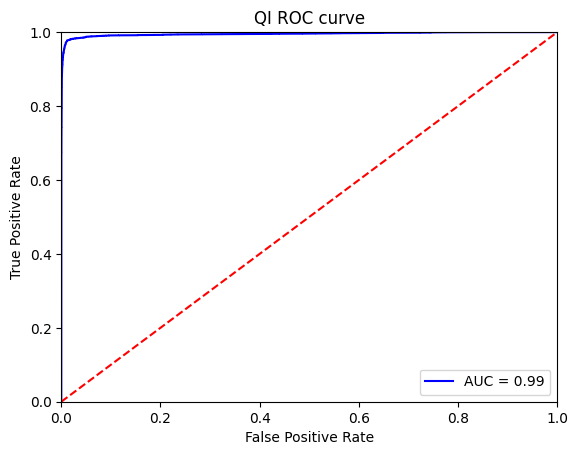

In [83]:
plot_roc(fpr, tpr, title="QI ROC curve")

In [ ]:
torch.save(TEXT, VOCAB_SAVE_PATH)

In [ ]:
torch.save(LABEL, LABEL_VOCAB_PATH)